# Beta experiment

## Introduction
This experiment utilizes historical prices data from the top 50 erc20 tokens fetched from Binance API. Primarly, to construct a portfolio of assets with weights $w_i$
 based on the Minimization of the risk:
 $$\min_w w^T \Sigma w + (\beta_\mathsf{X}-1)^2$$

## ERC20 top 50 assets
First, we query the top 50 erc20 tokens considering their 'marketcap' parameter using data from CoinMarketCap API.

In [18]:
import requests
import pandas as pd
import os
import requests
import pandas as pd

# Fetch tokens from CoinMarketCap
def fetch_top_erc20_tokens_from_coinmarketcap(limit=50):
    api_key = os.getenv('COINMARKETCAP_API_KEY')  # Fetch the API key from environment variables
    
    if not api_key:
        raise Exception("API key not found. Please set the COINMARKETCAP_API_KEY environment variable.")
    
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }
    params = {
        'start': '1',
        'limit': '200',  # Fetch a larger number and then filter down to ERC-20 tokens
        'convert': 'USD',
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    # Check if the response was successful
    if response.status_code != 200:
        raise Exception(f"Error fetching data from CoinMarketCap API: {response.status_code}, {response.text}")
    
    data = response.json()
    
    # Check if 'data' key is in the JSON response
    if 'data' not in data:
        raise KeyError("'data' key not found in the API response")
    
    # Extract ERC-20 tokens and ETH
    erc20_tokens = []
    eth_token = None
    for token in data['data']:
        if token['symbol'] == 'ETH':
            eth_token = token
        else:
            erc20_tokens.append(token)
    
    # Ensure ETH is always included in the list
    if eth_token:
        erc20_tokens.insert(0, eth_token)
    
    # Sort by market cap to get the top `limit` tokens, ensuring ETH is always included
    erc20_tokens = sorted(erc20_tokens, key=lambda x: x['quote']['USD']['market_cap'], reverse=True)
    erc20_tokens = erc20_tokens[:limit]
    
    # Convert to DataFrame
    df = pd.DataFrame(erc20_tokens)
    
    return df

# Construct the list objec
top_tokens = fetch_top_erc20_tokens_from_coinmarketcap()


## Historical Data
Then, using Binance API we obtain historical prices of the top 50 erc20 tokens compared to USDT.

In [19]:
from binance import Client
import pandas as pd
from datetime import datetime
import time

# Initialize the Binance client
# Replace 'YOUR_API_KEY' and 'YOUR_API_SECRET' with your actual Binance API key and secret
client = Client(api_key='bucKUSO8lvKBoUgg9Fjs9VvPK8S6vgiONoKYeJFVOQKxVWIbSQzzwuC7i9x8KBwb', api_secret='PWQ3HY0uPRNnLzOC28W5CFca6iqokcMDDbae3wBrcDNIfRMlQ3XaI7YwtcduTqnB')

# Define the function to get historical data
def get_historical_data(symbol, start_date):
    start_str = start_date.strftime('%d %b %Y %H:%M:%S')
    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, start_str)
    data = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 
        'close_time', 'quote_asset_volume', 'number_of_trades', 
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    data = data[['close']].astype(float)
    return data

# Initialize dictionary to store data
aux = {}

# Fetch historical data for each symbol
for symbol in top_tokens.symbol:
    try:
        historical_data = get_historical_data(symbol+'USDT', datetime(2023, 1, 1))
        aux[symbol] = historical_data['close']
        time.sleep(1)  # Sleep to avoid hitting API rate limits
    except Exception as e:
        print(f"Error retrieving data for {symbol}: {e}")

# Convert dictionary to DataFrame
df = pd.DataFrame(aux)

# Extract ETH Column
eth = df['ETH']

Error retrieving data for USDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for TON: APIError(code=-1121): Invalid symbol.
Error retrieving data for LEO: APIError(code=-1121): Invalid symbol.
Error retrieving data for KAS: APIError(code=-1121): Invalid symbol.
Error retrieving data for MNT: APIError(code=-1121): Invalid symbol.
Error retrieving data for CRO: APIError(code=-1121): Invalid symbol.
Error retrieving data for OKB: APIError(code=-1121): Invalid symbol.


In [4]:
# Drop ETH column and not useful columns
df = df.drop(columns=['DAI', 'FLOKI'])
df = df.drop(columns=df.columns[df.columns.str.contains('ETH|USD')])

# Beta Calculation
We want to utilize the concept of beta where Ethereum (ETH) is the reference market, together with a CAPM model to construct an optimally diversified portfolio (referred to as Portfolio X), composed of various assets $(x_1,x_2,\dots,x_N)$. To do this, we will need to establish a framework that considers both the individual asset volatilities and their correlations with Ethereum. 
The beta of Portfolio X relative to Ethereum (ETH) is the weighted sum of the betas of the individual assets in the portfolio:

$$ \beta_\mathsf{X} = \sum_{i=1}^n w_i \beta_{x_i} $$

where

$$ \beta_{x_i}= \frac{\text{Cov}(r_\mathsf{x_i}, r_\text{ETH})}{\text{Var}(r_\mathsf{ETH})} $$

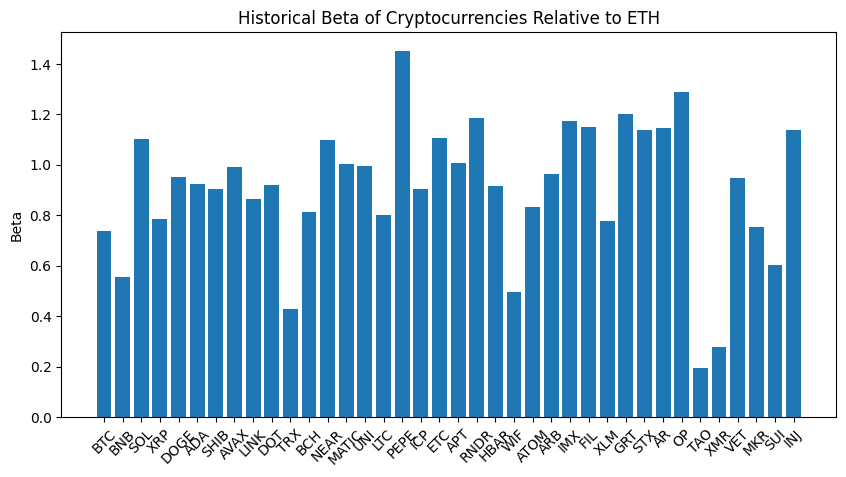

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

returns = df.pct_change()

# Compute daily return of Ethereum to use as the market return
eth_returns = eth.pct_change()

# Prepare to store beta values
betas = {}
means=[]
returns = returns.replace([np.nan, np.inf, -np.inf], 0)
eth_returns = eth_returns.replace([np.nan, np.inf, -np.inf], 0)

# Compute beta for each column (cryptocurrency) against ETH
for column in returns.columns:
    if column != 'eth':  # Skip calculating ETH's beta with itself
        covariance = returns[column].cov(eth_returns)
        variance = eth_returns.var()
        means.append(max(0,returns[column].mean()))

        beta = covariance / variance
        betas[column] = beta

# Plotting the betas
names = list(betas.keys())
values = list(betas.values())

plt.figure(figsize=(10, 5))
plt.bar(names, values)
plt.ylabel('Beta')
plt.title('Historical Beta of Cryptocurrencies Relative to ETH')
plt.xticks(rotation=45)
plt.show()


In [6]:
# Create DataFrame from the dictionary
beta_df = pd.DataFrame(list(betas.items()), columns=['Crypto', 'Beta'])

# Sort the DataFrame by 'Beta' in descending order
beta_df_sorted = beta_df.sort_values(by='Beta', ascending=False)
beta_df_sorted=beta_df_sorted.dropna()
beta_df_sorted.tail(20)


,Crypto,Beta
34,VET,0.947991
5,ADA,0.923777
9,DOT,0.919835
21,HBAR,0.916182
17,ICP,0.904829
6,SHIB,0.903828
8,LINK,0.863205
23,ATOM,0.832162
11,BCH,0.815110
15,LTC,0.803131


# Variance and Returns optimization
## Objective Function
The goal is to minimize variance and maximize returns. The objective function should incorporate the portfolio beta and the desired risk-return characteristics.

## Constraints
- The sum of the weights of all assets must equal 1: $\sum_{i=1}^n w_i = 1$
- Additional constraints may include limits on individual asset weights to avoid overexposure: $0 \leq w_i \leq 1$
- Optional constraints on the overall portfolio beta, such as $\beta_X \approx 1$, to maintain a market-neutral position or target a specific beta level.

## Risk and Return Models
- **Return Estimation**: Expected returns of assets $ \mu_i $ can be forecasted based on historical data or using a pricing model like the Capital Asset Pricing Model (CAPM).
- **Risk Estimation**: Covariance matrix of asset returns, $ \Sigma $, which captures the variance of each asset and the covariances between them.

## Optimization
- **Minimize Risk**: Solve for $ w $ in the quadratic optimization problem:
 $$\min_w w^T \Sigma w + (\beta_\mathsf{X}-1)^2$$
  subject to $ \sum_{i=1}^n w_i = 1 $ and other constraints.
  - **Maximize Utility** (e.g., Sharpe Ratio): Maximize
 $$ \max_w w^T \mu - r_f - (\beta_\mathsf{X}-1)^2$$
  where $ r_f $ is the risk-free rate.

In [13]:


import numpy as np
import pandas as pd
from scipy.optimize import minimize


risk_free_rate = 0.05
market_return = 0.5

# CAPM Expected Returns

# Simulated covariance matrix based on betas (scaled for demonstration)
# Normally, you'd calculate this based on historical returns data
cov_matrix = returns.cov()  # Simplified assumption
expected_returns=means

# Number of assets
num_assets = len(betas)

# Objective Functions
def portfolio_variance(weights):
    return weights.T @ cov_matrix @ weights

def portfolio_return(weights):
    return weights.T @ expected_returns

target_beta = 1.0

# Calculate portfolio beta as a function of weights
def portfolio_beta(weights):
    individual_betas = np.array(list(betas.values()))
    return np.dot(weights, individual_betas)

# Constraint to achieve the target beta
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights must sum to 1
    {'type': 'eq', 'fun': lambda x: (portfolio_beta(x) - target_beta)**2}  # Portfolio beta must meet target
]
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess (equal weighting)

init_guess = np.ones(num_assets) / num_assets
# Portfolio optimization for minimum variance
opt_min_var = minimize(portfolio_variance, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
min_var_weights = opt_min_var.x

print("Weights for Minimum Variance Portfolio:")
print(min_var_weights)
print("Expected Return:", portfolio_return(min_var_weights))
print("Expected Variance:", portfolio_variance(min_var_weights))

# Portfolio optimization for maximum Sharpe Ratio (Risk-Free Rate: 1%)
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights must sum to 1
    {'type': 'eq', 'fun': lambda x: -(portfolio_beta(x) - target_beta)**2}  # Portfolio beta must meet target
]
def neg_sharpe_ratio(weights):
    return - (portfolio_return(weights) - risk_free_rate) / np.sqrt(portfolio_variance(weights))

opt_max_sharpe = minimize(neg_sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
max_sharpe_weights = opt_max_sharpe.x

print("\nWeights for Maximum Sharpe Ratio Portfolio:")
print(max_sharpe_weights)
print("Expected Return:", portfolio_return(max_sharpe_weights))
print("Expected Variance:", portfolio_variance(max_sharpe_weights))

Weights for Minimum Variance Portfolio:
[7.29248091e-02 2.66303143e-02 2.21663478e-02 3.19703552e-02
 4.18127933e-02 2.48491853e-02 2.16840434e-18 6.01632593e-04
 6.14324222e-03 1.64744689e-02 1.55888240e-02 3.30681663e-18
 5.69206141e-19 4.90958319e-02 5.32062303e-02 3.18136666e-02
 7.16974396e-02 1.68026996e-04 1.20990458e-01 1.73472348e-18
 3.51094421e-03 2.25748590e-02 1.58743719e-04 8.89717252e-03
 9.99373866e-02 3.05841835e-02 2.31497346e-02 1.90518882e-02
 7.82618717e-03 1.35427733e-02 2.73761049e-18 9.09705271e-02
 1.06662436e-03 0.00000000e+00 2.43300591e-02 6.18970490e-02
 1.08420217e-19 6.36824194e-03]
Expected Return: 0.0027005235246783717
Expected Variance: 0.0010148202597443806

Weights for Maximum Sharpe Ratio Portfolio:
[1.00647771e-16 2.16538211e-16 0.00000000e+00 1.13551666e-15
 1.59801520e-16 0.00000000e+00 6.42639016e-16 0.00000000e+00
 5.12385374e-16 3.94700485e-16 2.53083832e-16 0.00000000e+00
 0.00000000e+00 9.37866455e-18 6.58823972e-16 7.00325367e-16
 1.0267898

Then, we Filter non zero weights and their corresponfing symbol

In [15]:
res={}
for i in range(num_assets):
  name=df.columns[i]
  res[name]=round(max_sharpe_weights[i],3)

filtered_res = {key: value for key, value in res.items() if value != 0}


print('weights =', filtered_res)

beta = 0
for key, value in filtered_res.items():
    beta += beta_df[beta_df['Crypto']==key].Beta.values[0]*value
beta

weights = {'RNDR': 0.763, 'WIF': 0.16, 'TAO': 0.077}


1.0003974054362932

# Results
In order to present an investment strategy, we compare the returns given by the weights based portfolio with the ETH returns. 

* In the figure 1 we display the combined portfolio returns over time compared to ETH returns. 

* Figure 2 shows the Portfolio return relative to ETH return

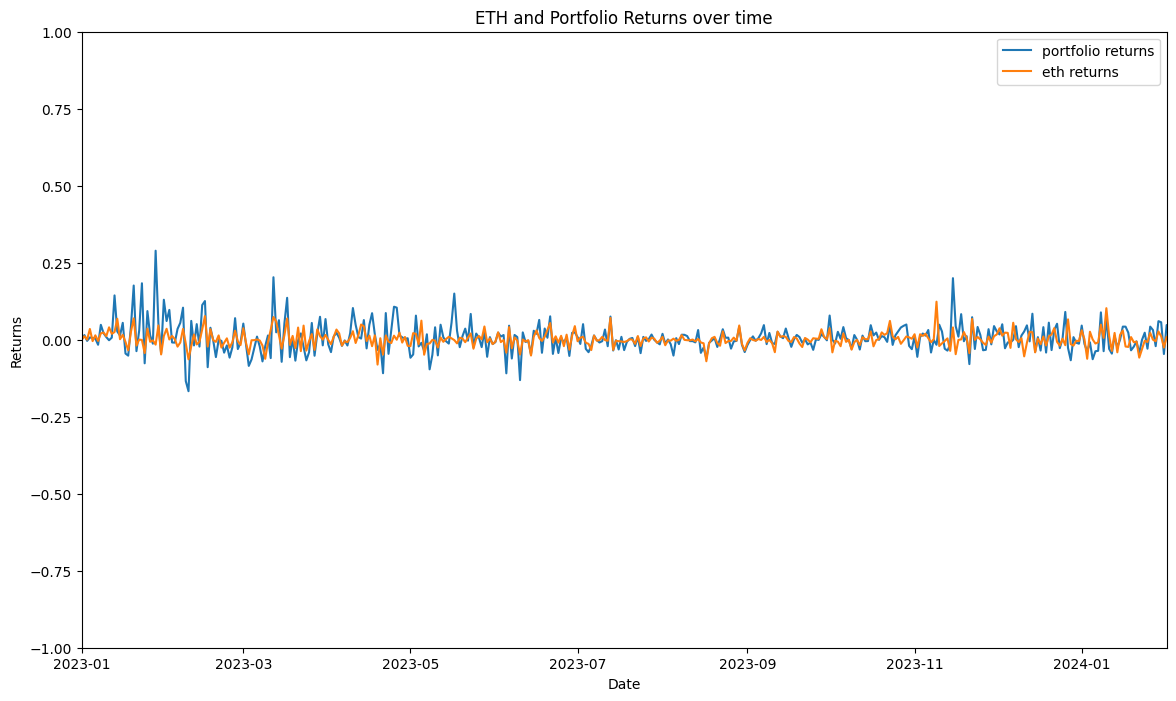

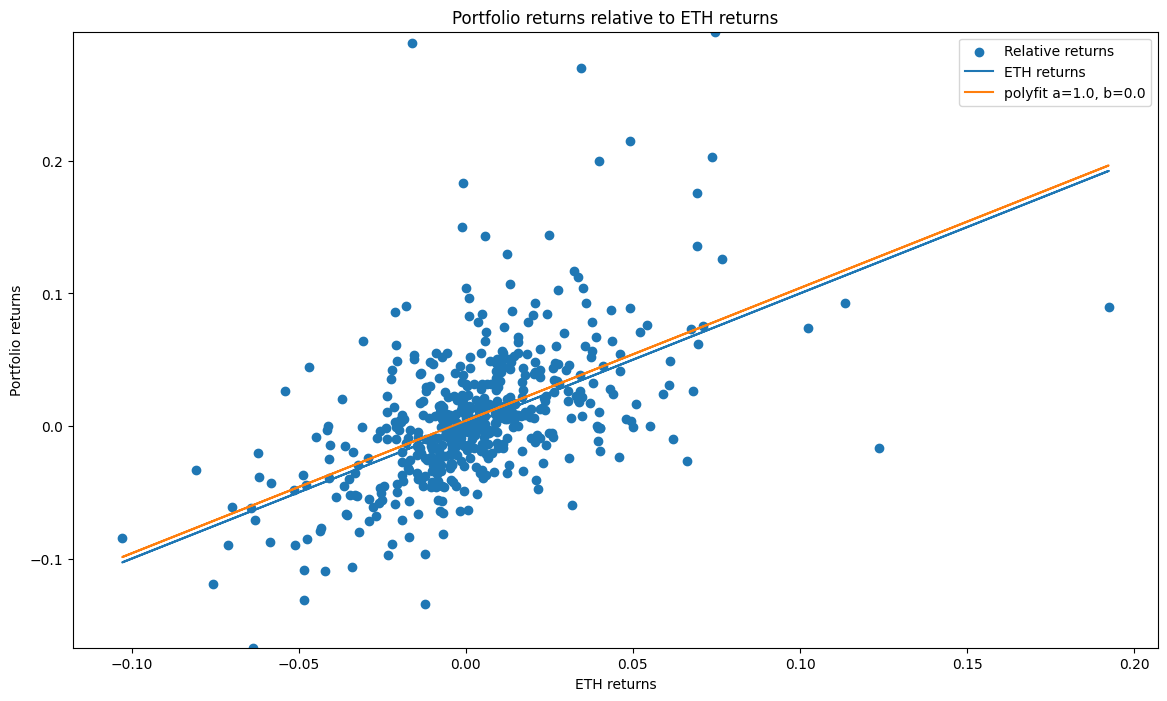

In [16]:
portfolio_sum = 0

for key, value in filtered_res.items():
    portfolio_sum += returns[key] * value

portfolio_sum = portfolio_sum.fillna(0) 
# Plot the relative prices
plt.figure(figsize=(14, 8))

plt.plot(portfolio_sum.index, portfolio_sum.values, label='portfolio returns')
plt.plot(eth_returns.index, eth_returns.values , label='eth returns')
plt.title('ETH and Portfolio Returns over time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.ylim(-1, 1)
plt.xlim([datetime(2023,1 , 1), datetime(2024, 2, 1)])
plt.legend()
plt.show()

# Plot the relative prices
plt.figure(figsize=(14, 8))

plt.scatter(eth_returns.values, portfolio_sum.values , label='Relative returns')
plt.plot(eth_returns.values, eth_returns.values , label='ETH returns')
a,b = np.polyfit(x=eth_returns.values, y=portfolio_sum.values,deg=1)
plt.plot(eth_returns.values, a*eth_returns.values+b, label=f"polyfit a={round(a,2)}, b={round(b,2)}")
plt.title('Portfolio returns relative to ETH returns')
plt.xlabel('ETH returns')
plt.ylabel('Portfolio returns')
plt.ylim(min(portfolio_sum.values),max(portfolio_sum.values))
plt.xlim()
plt.legend()
plt.show()


Lastly, we simulate how an initial investment of 1000 generates returns over the portfolio constructed and we compare it investing the same amount in ETH

Text(0, 0.5, 'Portfolio')

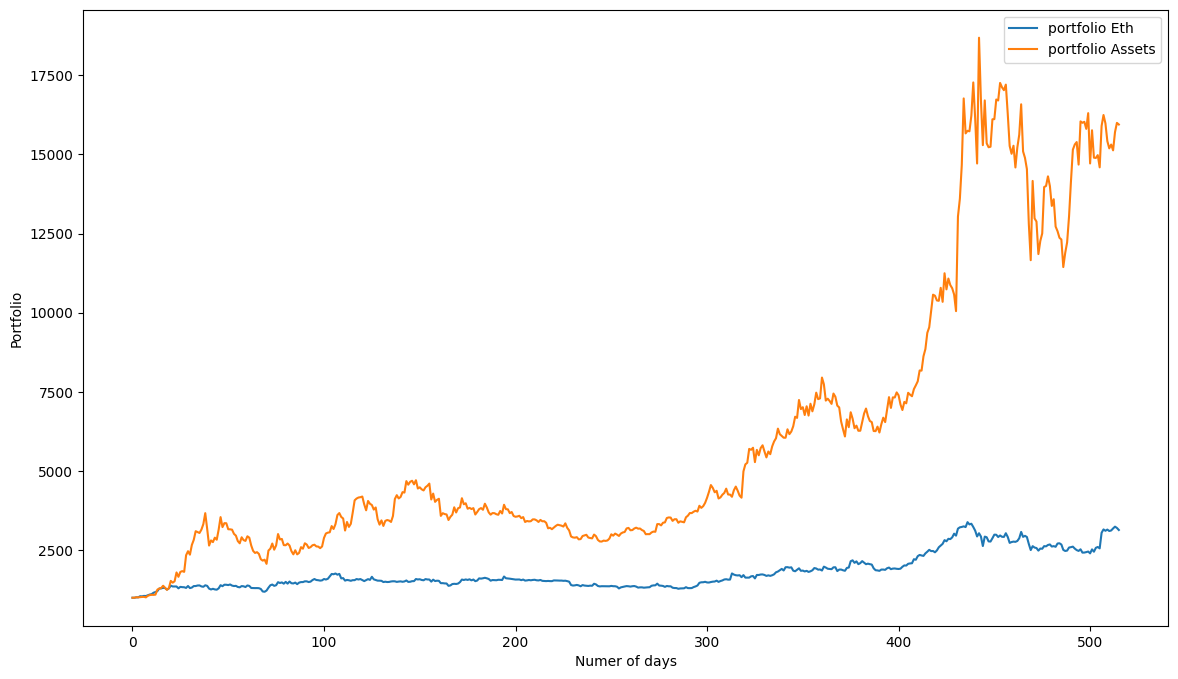

In [17]:
n = len(eth_returns.index)
portfolio_eth = np.zeros(n)
portfolio_assets = np.zeros(n)
v0 = 1000
portfolio_eth[0] = v0
portfolio_assets[0] = v0

for i in range (1, n):
    portfolio_eth[i] = (1+eth_returns[i-1])*portfolio_eth[i-1]
    portfolio_assets[i] = (1+portfolio_sum[i-1])*portfolio_assets[i-1]

# Plot
plt.figure(figsize=(14, 8))
plt.plot(portfolio_eth , label='portfolio Eth')
plt.plot(portfolio_assets , label='portfolio Assets')
plt.legend()
plt.xlabel('Numer of days')
plt.ylabel('Portfolio')
